# Setup

In [1]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import nibabel as nib
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models  # pretrained models
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.models import AlexNet_Weights, VGG16_Weights, VGG16_BN_Weights, VGG19_BN_Weights, VGG19_Weights
from torchvision.models import efficientnet_b2, efficientnet_b5, EfficientNet_B2_Weights, EfficientNet_B5_Weights
from torchvision.models import ResNet50_Weights
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights
from torchvision import transforms
from pytorchcv.model_provider import get_model as ptcv_get_model

from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression, Ridge
from scipy.stats import pearsonr as corr

# Nets

## AlexNet

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights=AlexNet_Weights.IMAGENET1K_V1)
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [3]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


In [3]:
model_layer = ['features.11', 'features.12']
feature_extractor = create_feature_extractor(model, return_nodes=model_layer)

In [4]:
type(feature_extractor)

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

### Test

In [31]:
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights
from torchvision.models import AlexNet_Weights

imagenet_V2_transform = transforms.Compose([
    transforms.Resize((224,224)), # resize the images to 224x224 pixels (256x256)
    # transforms.CenterCrop(224), # IN THE OLDER SCRIPT: no center crop, only resize to 224x224
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    # normalize the images color channels
    # mean: [0.485, 0.456, 0.406] for the three channels
    # std: [0.229, 0.224, 0.225] for the three channels
])

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()
model_layer = ['features.11', 'features.12']
feature_extractor = create_feature_extractor(model, return_nodes=model_layer)
feature_extractor.eval()

AlexNet(
  (features): Module(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)

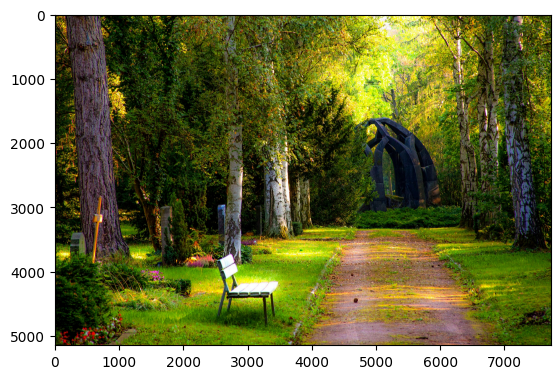

In [33]:
from PIL import Image

image = Image.open('..\\..\\files\\test_images\\park.jpg')

X = imagenet_V2_transform(image).unsqueeze(dim=0).to(device)

# show image "image"
plt.imshow(image)


In [34]:
output = feature_extractor(X)

In [35]:
output.keys()

dict_keys(['features.11', 'features.12'])

In [36]:
output['features.11']

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[4.3481, 1.7880, 0.0000,  ..., 1.3723, 3.6282, 5.4469],
          [4.0108, 0.6678, 0.7569,  ..., 1.7633, 4.0915, 4.1990],
          [3.8861, 0.5009, 0.0000,  ..., 2.6111, 3.6229, 5.4718],
          ...,
          [2.7469, 5.3437, 2.7298,  ..., 0.2958, 0.0000, 0.7166],
          [1.4845, 3.2119, 0.1022,  ..., 0.0000, 0.0000, 0.0000],
          [3.9547, 0.5977, 0.0000,  ..., 1.4278, 0.0000, 0.0000]],

         [[1.1517, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [2.6232, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [2.7557, 0.1883, 0.0000,  ..., 0

In [37]:
output['features.11'].shape

torch.Size([1, 256, 13, 13])

In [14]:
ft = output['features.11']
ft = torch.flatten(ft, start_dim=1).detach().cpu().numpy()

In [15]:
ft.shape

(1, 43264)

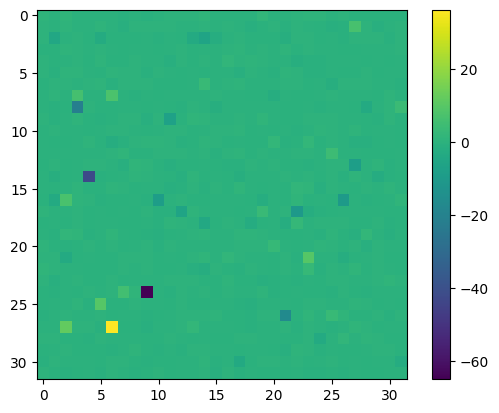

In [ ]:
image_size = 350

import numpy as np
import matplotlib.pyplot as plt

# Assuming features is a numpy array of shape (1, 1024)
features = output 
features = features.cpu().detach().numpy()

# Reshape features to a square image shape
image_size = int(np.sqrt(features.shape[1]))
feature_image = features.reshape((image_size, image_size))

plt.imshow(feature_image, cmap='viridis')  # Use a suitable colormap
plt.colorbar()
plt.show()

## ZFNet

In [3]:
model = ptcv_get_model("ZFNet", pretrained=True)
model.eval()

AlexNet(
  (features): Sequential(
    (stage1): Sequential(
      (unit1): AlexConv(
        (conv): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
        (activ): ReLU(inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (stage2): Sequential(
      (unit1): AlexConv(
        (conv): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
        (activ): ReLU(inplace=True)
      )
      (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (stage3): Sequential(
      (unit1): AlexConv(
        (conv): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activ): ReLU(inplace=True)
      )
      (unit2): AlexConv(
        (conv): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activ): ReLU(inplace=True)
      )
      (unit3): AlexConv(
        (conv): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [5]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.stage1.unit1.conv', 'features.stage1.unit1.activ', 'features.stage1.unit1.local_response_norm', 'features.stage1.pool1', 'features.stage2.unit1.conv', 'features.stage2.unit1.activ', 'features.stage2.unit1.local_response_norm', 'features.stage2.pool2', 'features.stage3.unit1.conv', 'features.stage3.unit1.activ', 'features.stage3.unit2.conv', 'features.stage3.unit2.activ', 'features.stage3.unit3.conv', 'features.stage3.unit3.activ', 'features.stage3.pool3', 'size', 'view', 'output.fc1.fc', 'output.fc1.activ', 'output.fc1.dropout', 'output.fc2.fc', 'output.fc2.activ', 'output.fc2.dropout', 'output.fc3']


## ResNet-50

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.relu_1', 'layer1.0.conv3', 'layer1.0.bn3', 'layer1.0.downsample.0', 'layer1.0.downsample.1', 'layer1.0.add', 'layer1.0.relu_2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.relu_1', 'layer1.1.conv3', 'layer1.1.bn3', 'layer1.1.add', 'layer1.1.relu_2', 'layer1.2.conv1', 'layer1.2.bn1', 'layer1.2.relu', 'layer1.2.conv2', 'layer1.2.bn2', 'layer1.2.relu_1', 'layer1.2.conv3', 'layer1.2.bn3', 'layer1.2.add', 'layer1.2.relu_2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.relu_1', 'layer2.0.conv3', 'layer2.0.bn3', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_2', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.relu_1', 'layer2.1.conv3', 'layer2.1.bn3', 'layer2.1.add', 'layer2.1.rel

## RetinaNet (ResNet-50 Backbone)

In [5]:
model = models.detection.retinanet_resnet50_fpn(weights = RetinaNet_ResNet50_FPN_Weights.COCO_V1)
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In questo modo sottostante isolo i primi due gruppi di retina net (backbone e feature pyramid, come nel paper di anbebe) -> **BackboneWithFPN**

In [3]:
model.backbone = model.backbone.body.layer1[:-1]

In [4]:
model

RetinaNet(
  (backbone): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(64, eps=0.0)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): FrozenBatchNorm2d(256, eps=0.0)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(256, eps=0.0)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): FrozenBatchNorm2d(64, eps=0.0)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [ ]:
# list(model.children())[:-3] -> alternativa, non ho capito ocome si usa

In [7]:
train_nodes, _ = get_graph_node_names(model.backbone)
print(train_nodes)
print([node for node in train_nodes if "relu_2" in node])

['x', 'body.conv1', 'body.bn1', 'body.relu', 'body.maxpool', 'body.layer1.0.conv1', 'body.layer1.0.bn1', 'body.layer1.0.relu', 'body.layer1.0.conv2', 'body.layer1.0.bn2', 'body.layer1.0.relu_1', 'body.layer1.0.conv3', 'body.layer1.0.bn3', 'body.layer1.0.downsample.0', 'body.layer1.0.downsample.1', 'body.layer1.0.add', 'body.layer1.0.relu_2', 'body.layer1.1.conv1', 'body.layer1.1.bn1', 'body.layer1.1.relu', 'body.layer1.1.conv2', 'body.layer1.1.bn2', 'body.layer1.1.relu_1', 'body.layer1.1.conv3', 'body.layer1.1.bn3', 'body.layer1.1.add', 'body.layer1.1.relu_2', 'body.layer1.2.conv1', 'body.layer1.2.bn1', 'body.layer1.2.relu', 'body.layer1.2.conv2', 'body.layer1.2.bn2', 'body.layer1.2.relu_1', 'body.layer1.2.conv3', 'body.layer1.2.bn3', 'body.layer1.2.add', 'body.layer1.2.relu_2', 'body.layer2.0.conv1', 'body.layer2.0.bn1', 'body.layer2.0.relu', 'body.layer2.0.conv2', 'body.layer2.0.bn2', 'body.layer2.0.relu_1', 'body.layer2.0.conv3', 'body.layer2.0.bn3', 'body.layer2.0.downsample.0', 'b

Osservando il codice di RetinaNet e in particolare di BackbonewithFPN emerge come il blocco `fpn`:
- Se scelto con il feature_extractor, manda in output un dizionario conenenete tutte e feature maps (5 in totale) dei layer presenti nel blocco della feature pyramid
- Ricorda che: feature_extractor genera in output già un dizionario dei layer selezionati
- Quindi in qquesto caso avremo un dizionario di dizionari (va sistemata la funzione di estrazione)

## VGG-16

In [2]:
model = torch.hub.load('pytorch/vision:v0.10.0', 
                        'vgg16', 
                        weights=VGG16_Weights.IMAGENET1K_V1)
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
model = torch.hub.load('pytorch/vision:v0.10.0', 
                        'vgg16_bn', 
                        weights=VGG16_BN_Weights.IMAGENET1K_V1)
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [5]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'features.37', 'features.38', 'features.39', 'features.40', 'features.41', 'features.42', 'features.43', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


## VGG-19

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 
                        'vgg19', 
                        weights=VGG19_Weights.IMAGENET1K_V1)
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 
                        'vgg19_bn', 
                        weights=VGG19_BN_Weights.IMAGENET1K_V1)
model.eval() # set the model to evaluation mode, since you are not training it

Using cache found in C:\Users\giorg/.cache\torch\hub\pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [4]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'features.13', 'features.14', 'features.15', 'features.16', 'features.17', 'features.18', 'features.19', 'features.20', 'features.21', 'features.22', 'features.23', 'features.24', 'features.25', 'features.26', 'features.27', 'features.28', 'features.29', 'features.30', 'features.31', 'features.32', 'features.33', 'features.34', 'features.35', 'features.36', 'features.37', 'features.38', 'features.39', 'features.40', 'features.41', 'features.42', 'features.43', 'features.44', 'features.45', 'features.46', 'features.47', 'features.48', 'features.49', 'features.50', 'features.51', 'features.52', 'avgpool', 'flatten', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6']


## EfficientNet B2

In [2]:
model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
model.eval() # set the model to evaluation mode, since you are not training it

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [4]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1.0.block.0', 'features.1.0.block.1', 'features.1.0.block.2', 'features.1.1.block.0', 'features.1.1.block.1', 'features.1.1.block.2', 'features.1.1.stochastic_depth', 'features.1.1.add', 'features.2.0.block.0', 'features.2.0.block.1', 'features.2.0.block.2', 'features.2.0.block.3', 'features.2.1.block.0', 'features.2.1.block.1', 'features.2.1.block.2', 'features.2.1.block.3', 'features.2.1.stochastic_depth', 'features.2.1.add', 'features.2.2.block.0', 'features.2.2.block.1', 'features.2.2.block.2', 'features.2.2.block.3', 'features.2.2.stochastic_depth', 'features.2.2.add', 'features.3.0.block.0', 'features.3.0.block.1', 'features.3.0.block.2', 'features.3.0.block.3', 'features.3.1.block.0', 'features.3.1.block.1', 'features.3.1.block.2', 'features.3.1.block.3', 'features.3.1.stochastic_depth', 'features.3.1.add', 'features.3.2.block.0', 'features.3.2.block.1', 'features.3.2.block.2', 'features.3.2.block.3', 'features.3.2.stochastic_depth', 'features.3.2.a

## EfficientNet-B5

In [4]:
model = efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)
model.eval() # set the model to evaluation mode, since you are not training it

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to C:\Users\giorg/.cache\torch\hub\checkpoints\efficientnet_b5_lukemelas-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [5]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

['x', 'features.0', 'features.1.0.block.0', 'features.1.0.block.1', 'features.1.0.block.2', 'features.1.1.block.0', 'features.1.1.block.1', 'features.1.1.block.2', 'features.1.1.stochastic_depth', 'features.1.1.add', 'features.1.2.block.0', 'features.1.2.block.1', 'features.1.2.block.2', 'features.1.2.stochastic_depth', 'features.1.2.add', 'features.2.0.block.0', 'features.2.0.block.1', 'features.2.0.block.2', 'features.2.0.block.3', 'features.2.1.block.0', 'features.2.1.block.1', 'features.2.1.block.2', 'features.2.1.block.3', 'features.2.1.stochastic_depth', 'features.2.1.add', 'features.2.2.block.0', 'features.2.2.block.1', 'features.2.2.block.2', 'features.2.2.block.3', 'features.2.2.stochastic_depth', 'features.2.2.add', 'features.2.3.block.0', 'features.2.3.block.1', 'features.2.3.block.2', 'features.2.3.block.3', 'features.2.3.stochastic_depth', 'features.2.3.add', 'features.2.4.block.0', 'features.2.4.block.1', 'features.2.4.block.2', 'features.2.4.block.3', 'features.2.4.stoch

## DINOv2

### Pre-trained models

In [281]:
resnet50 = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
resnet50.eval()

Using cache found in C:\Users\giorg/.cache\torch\hub\facebookresearch_dino_main


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
model.eval()

Using cache found in C:\Users\giorg/.cache\torch\hub\facebookresearch_dinov2_main
xFormers not available
xFormers not available


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedT

In [61]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
model.eval()

Using cache found in C:\Users\giorg/.cache\torch\hub\facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to C:\Users\giorg/.cache\torch\hub\checkpoints\dinov2_vitb14_pretrain.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedT

In [6]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
model.eval()

Using cache found in C:\Users\giorg/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1):

The pytorch implementation of DINOv2 is itself a feature extractor, so it doesn't need to select a feature layer
- See: https://github.com/facebookresearch/dinov2/issues/89

In [247]:
for param in model.parameters():
    param.requires_grad = False

In [60]:
train_nodes, _ = get_graph_node_names(model)
print(train_nodes)

TraceError: Proxy object cannot be iterated. This can be attempted when the Proxy is used in a loop or as a *args or **kwargs function argument. See the torch.fx docs on pytorch.org for a more detailed explanation of what types of control flow can be traced, and check out the Proxy docstring for help troubleshooting Proxy iteration errors

Il numero di blocchi da cui è possibile estrarre feature è `len(model.blocks)`
- small (s) e base (b) hanno 12 blocchi
- large (l) ha 24 blocchi
- giant (g) ha 40 blocchi

In [208]:
len(model.blocks)

12

La **dimensione degli embedding** (lunghezza feature maps) è:
- small 384
- base 768
- large 1024
- giant 1536

### nn.Sequential

Questo metodo prevede di "tagliare" un certo numero di blocchi dal modulo "blocks"

In [11]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights
from torchvision.models import AlexNet_Weights

dinov2_transform = transforms.Compose([
    transforms.Resize((350,350), interpolation=InterpolationMode.BICUBIC), # resize the images to 224x224 pixels (256x256)
    transforms.CenterCrop(350),
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    # normalize the images color channels
    # mean: [0.485, 0.456, 0.406] for the three channels
    # std: [0.229, 0.224, 0.225] for the three channels
])

In [249]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedT

`model_layer` indicherà DA quale dei blocchi, da 1 a len(model.blocks) andare a tagliare (quelli dopo sono elminati)

In [217]:
model_layer = "2"
number_of_blocks = len(model.blocks)
if model_layer == "1":
    print(f"Using Full DINOv2 Model (block {number_of_blocks})")
    feature_extractor = model
else:
    subcract = number_of_blocks - int(model_layer)
    print(f"Using Intermediate DINOv2 Model Layer (block {model_layer})")
    modules=list(model.blocks.children())[:-subcract]
    feature_extractor = model
    feature_extractor.blocks =nn.Sequential(*modules)
feature_extractor.eval()

Using Intermediate DINOv2 Model Layer (block 2)


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): Sequential(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedT

Questp metodo genera i `x_norm_clstoken` che quindi avranno dimensione:
- (batch_dim, embedding size) es (64, 384) 

### DINOv2 Class FUnction

In [132]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
for param in model.parameters():
    param.requires_grad = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

Using cache found in C:\Users\giorg/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedT

In [159]:
dinov2_transform = transforms.Compose([
    transforms.Resize((350,350), interpolation=InterpolationMode.BICUBIC), # resize the images to 224x224 pixels (256x256)
    transforms.CenterCrop(350),
    transforms.ToTensor(), # convert the images to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    # normalize the images color channels
    # mean: [0.485, 0.456, 0.406] for the three channels
    # std: [0.229, 0.224, 0.225] for the three channels
])

transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

from torchvision import transforms as pth_transforms

preprocess = pth_transforms.Compose([
        pth_transforms.Resize(256, interpolation=3),
        pth_transforms.CenterCrop(224),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

dino_resnet50_preprocess = pth_transforms.Compose([
            pth_transforms.Resize(256, interpolation=3),
            pth_transforms.CenterCrop(224),
            pth_transforms.ToTensor(),
            pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

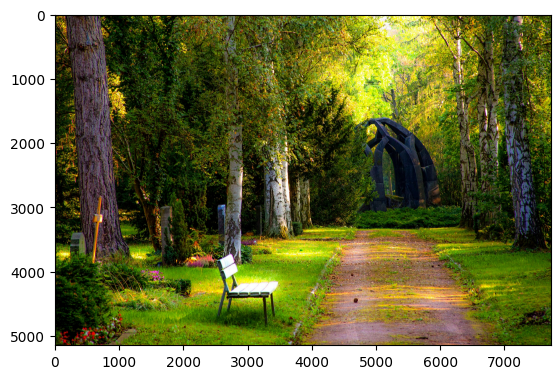

In [158]:
from PIL import Image

image = Image.open('..\\..\\files\\test_images\\park.jpg')

X = dinov2_transform(image).unsqueeze(dim=0).to(device)

# show image "image"
plt.imshow(image)

#### forward_features() e get_intermediate_layers()

##### forward_features()

Vedi definizione modello DINOv2 in: https://github.com/facebookresearch/dinov2/blob/main/dinov2/models/vision_transformer.py#L65

È un metodo del modello pretrained DINOv2 (s, b, g e l):

``` python
def forward_features(self, x, masks=None):
    if isinstance(x, list):
        return self.forward_features_list(x, masks)

    x = self.prepare_tokens_with_masks(x, masks)

    for blk in self.blocks:
        x = blk(x)

    x_norm = self.norm(x)
    return {
        "x_norm_clstoken": x_norm[:, 0],
        "x_norm_patchtokens": x_norm[:, 1:],
        "x_prenorm": x,
        "masks": masks,
    }
```

Di fatto definisce quali feature vengono estratte da DINOv2 e passate quando si passa una immagine.

Assumiamo si star usando DINOv2-S (embedding lenght 384) ma il discorso vale anche per le atre versioni.

- 'x'/'`x_prenorm`' sono le feautre che escono dal modulo 'blocks' di DINOv2
- `x_norm` sono le feature che escono dal penultimo layer di DINOv2:
`(norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)`
Che hanno shape torch.Size(`[1, 626, 384]`), infatti usando gli **hook** per estrarre le feature dai layer intermedi di **blocks** si ottengono feature con quella dimensione.
- `x_norm_clstoken`, shape `([1, 384])` è la prima colonna di x_norm `x_norm[:, 0]`. Il **CLS Token** è il token (embedding) usato per i task di classificazione delle immagini, è un token che riassume globalmente le informazioni delle immagini, per questo si usa in questo task. **Sono le feature restituite quando fai un semplice model(immagine)**, infatti il forward dei modelli è:
    ``` python
    def forward(self, *args, is_training=False, **kwargs):
        ret = self.forward_features(*args, **kwargs)
        if is_training:
            return ret
        else:
            return self.head(ret["x_norm_clstoken"])
    ```
    - A far si che `model(immagine)` restituisca `x_norm_clstoken` è il layer `(head)` che effettua il forward.
- '`x_norm_patchtokens`' (`[1, 625, 384]`) sono i token delle **patch** in cui è divisa l'immagine, tutte feature map utili per altri task (retrieval, segmentation), sono di fatto tutti gli altri token (escluso il CLS token, infatti sono 625 e non 626), ottiene con `x_norm[:, 1:]`.


In [134]:
model.forward_features(X).keys()

dict_keys(['x_norm_clstoken', 'x_norm_patchtokens', 'x_prenorm', 'masks'])

In [65]:
for i in model.forward_features(X).keys():
    if i != 'masks':
        print("Shape of feature map: ", i, model.forward_features(X)[i].shape)

Shape of feature map:  x_norm_clstoken torch.Size([1, 384])
Shape of feature map:  x_norm_patchtokens torch.Size([1, 625, 384])
Shape of feature map:  x_prenorm torch.Size([1, 626, 384])


##### get_intermediate_layers()

```python
features = model.get_intermediate_layers(immagine o immagini, Lista di Layers o n last layers to take, return_class_token=True o False)
```
è la funzione che si occupa che di restituire gli embedding/feature map intermedie dei blocchi del modulo **blocks** di DINOv2. 


Vedi codice delle moduli:

```python
def _get_intermediate_layers_not_chunked(self, x, n=1):
    x = self.prepare_tokens_with_masks(x)
    # If n is an int, take the n last blocks. If it's a list, take them
    output, total_block_len = [], len(self.blocks)
    blocks_to_take = range(total_block_len - n, total_block_len) if isinstance(n, int) else n
    for i, blk in enumerate(self.blocks):
        x = blk(x)
        if i in blocks_to_take:
            output.append(x)
    assert len(output) == len(blocks_to_take), f"only {len(output)} / {len(blocks_to_take)} blocks found"
    return output

def _get_intermediate_layers_chunked(self, x, n=1):
    x = self.prepare_tokens_with_masks(x)
    output, i, total_block_len = [], 0, len(self.blocks[-1])
    # If n is an int, take the n last blocks. If it's a list, take them
    blocks_to_take = range(total_block_len - n, total_block_len) if isinstance(n, int) else n
    for block_chunk in self.blocks:
        for blk in block_chunk[i:]:  # Passing the nn.Identity()
            x = blk(x)
            if i in blocks_to_take:
                output.append(x)
            i += 1
    assert len(output) == len(blocks_to_take), f"only {len(output)} / {len(blocks_to_take)} blocks found"
    return output

def get_intermediate_layers(
    self,
    x: torch.Tensor,
    n: Union[int, Sequence] = 1,  # Layers or n last layers to take
    reshape: bool = False,
    return_class_token: bool = False,
    norm=True,
) -> Tuple[Union[torch.Tensor, Tuple[torch.Tensor]]]:
    if self.chunked_blocks:
        outputs = self._get_intermediate_layers_chunked(x, n)
    else:
        outputs = self._get_intermediate_layers_not_chunked(x, n)
    if norm:
        outputs = [self.norm(out) for out in outputs]
    class_tokens = [out[:, 0] for out in outputs]
    outputs = [out[:, 1:] for out in outputs]
    if reshape:
        B, _, w, h = x.shape
        outputs = [
            out.reshape(B, w // self.patch_size, h // self.patch_size, -1).permute(0, 3, 1, 2).contiguous()
            for out in outputs
        ]
    if return_class_token:
        return tuple(zip(outputs, class_tokens))
    return tuple(outputs)
```

Parametri:
- il **primo: x** è il batch di immagini preprocessate
- il **secondo: n**:
  - `n` = ultimi n layer (blocchi di blocks) da prendere
  - Lista di numeri interi `[n1, n2, n4, ...]` = prendi output del di `[block.n1, block.n2, block.n4]`
- **return_class_token=False** -> Se **False** restituisce solo i **patch tokens**, se **True** restituisce una **LISTA**, dove il primo elemento è il **CLS token** e il secondo il **patch token**
- il **norm=True**
  - Indica se applicato il norm_layer agli embedding (di base true)


**Output/Funzionamento** 

0. Considerando 
   - x = batch di 64 immagini
   - n = `[1, 2, 4]`:
   - norm = True
   - return_class_token=False
1. `features = model.get_intermediate_layers(x = X,n = [1, 2, 4], norm = True, return_class_token = True)`
2. Features è:
   - Una tupla di lunghezza `len(n)`, dove ogni elmento sono le feature estratte dal layer `[block.n1, block.n2, block.n4]`
   - Prendendo `features[0]` (le features di blocks.1)
     - È un **tupla** anche questa di due elementi
       - Il primo `features[0][0]` è l'insieme delle **patch tokens** `[(64, 625, 384)]`
       - Il secondo è l'insieme delle **CLS TOKEN** `[(64, 384)]` - `(numero immagini batch, lunghezza embedding)`
         - A NOI INTERESSANO QUESTI
         - La loro struttura va bene per essere usata come `ft` nelle funzioni di feature extraction

Il numero di blocchi come sempre è:

In [119]:
len(model.blocks) 

12

In [116]:
features = model.get_intermediate_layers(x = X,n = [1, 2, 4], norm = True, return_class_token = True)

In [128]:
len(list(features))

3

In [122]:
print(type(features))
print(len(features))

<class 'tuple'>
3


In [123]:
print(type(features[0]))
print(len(features[0]))

<class 'tuple'>
2


In [124]:
print(type(features[0][0]))
print(features[0][0].shape)

<class 'torch.Tensor'>
torch.Size([1, 625, 384])


In [125]:
print(type(features[0][1]))
print(features[0][1].shape)

<class 'torch.Tensor'>
torch.Size([1, 384])


In [129]:
n = [1, 2, 4]
model_layers = ["blocks." + str(number) for number in n]
model_layers

['blocks.1', 'blocks.2', 'blocks.4']

In [ ]:
ordered_dict = OrderedDict((key, value[1]) for key, value in zip(string_list, tuple_list))

In [51]:
for i in range(0,len(model.get_intermediate_layers(X, [1,2,3]))):
    print(model.get_intermediate_layers(X, [1,2,3])[i].shape)

torch.Size([1, 625, 384])
torch.Size([1, 625, 384])
torch.Size([1, 625, 384])


#### Creo classe da usare come feature_extractor

In [139]:
from collections import OrderedDict

class DINOv2FeatureExtractor:
    def __init__(self, model, return_layers, reshape = False, return_class_token = True, norm = True):
        """Wraps a Pytorch DINOv2 module to get intermediate values
        Arguments:
            model {nn.module} -- The Pytorch module to call
            return_layers {list} -- List of blocks layer number e.g. [1,2,3] will take output [blocks.1,blocks.2,blocks.3] 
            reshape {bool} -- If True, the output of each layer is reshaped to a 2D tensor with same shape as the output of input image
            return_class_token {bool} -- If True, the output will be a 2-element tuple with patches tokens and CLS token respectively first and second element
            norm {bool} -- If True, the output of each layer is normalized
        Returns:
            When initialized, the class returns a feature extractor callable on a batch of images.
            When the feature extractor is called, it returns an OrderedDict with the requested layers as keys and the corresponding features as values.
        """
        self.model = model
        if isinstance(model, list):
            self.return_layers = [int(string) for string in return_layers]
        else:
            print("Set model layers as lists even if single layer extraction.")
            return_layers = [return_layers]
            self.return_layers = [int(string) for string in return_layers]
        self.reshape = reshape
        self.return_class_token = return_class_token
        self.norm = norm
        self.number_of_blocks = len(self.model.blocks)
        
    def __call__(self, X):
        """
        Arguments:
            X: batch of images (torch tensor)
        """
        ret = OrderedDict()
        model_layers = ["blocks." + str(number) for number in self.return_layers]
        try:
            features = self.model.get_intermediate_layers(x = X, n = self.return_layers, reshape = self.reshape, return_class_token = self.return_class_token, norm = self.norm)
        except AttributeError as e:
            raise AttributeError(f'Module/s {self.return_layers} not found')
        ret = OrderedDict((key, value[1]) for key, value in zip(model_layers, features))
        return ret

In [140]:
feature_extractor = DINOv2FeatureExtractor(model, return_layers = ["1","2","3"], reshape = False, return_class_token = True, norm = True)

In [141]:
ft = feature_extractor(X)

In [149]:
ft.keys()

odict_keys(['blocks.1', 'blocks.2', 'blocks.3'])

### FOrward

Funziona ma complesso, lo eviterei

In [17]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
for param in model.parameters():
    param.requires_grad = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()

Using cache found in C:\Users\giorg/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedT

In [ ]:
class DINOv2Bottom(nn.Module):
    def __init__(self, num_outputs):
        super(CustomNet, self).__init__()
        
        # Caricamento del modello VGG-19 pre-addestrato
        model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        
        # Freeze the pre-trained layers
        for param in model.parameters():
            param.requires_grad = False
        
        # Utilizziamo solo i layer di feature extraction senza gli ultimi layer completamente connessi
        self.features = nn.Sequential(*list(model.features.children()))
        
        # Aggiunta del layer di average pooling
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        
        # Aggiunta del layer completamente connesso per la regressione
        self.fc = nn.Linear(512 * 7 * 7, num_outputs)  # L'input size 512 è determinato dal numero di feature maps generate dall'ultimo layer di VGG-19
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [8]:
#from timm.layers import PatchEmbed
from torch import nn
class DINOv2Bottom(nn.Module):
    def __init__(self, original_model):
        super(DINOv2Bottom, self).__init__()
        self.patch_embed = original_model.patch_embed
        features = list(original_model.blocks)
        self.blocks = nn.ModuleList(features)
        # self.blocks = nn.ModuleList(original_model.blocks.children())
        
    def forward(self, x):
        x = self.patch_embed(x)
        results = []
        for ii,model in enumerate(self.blocks):
            x = model(x)
            if ii in {1}:
                results.append(x)
        
        return results
        # return x

In [9]:
feature_extractor = DINOv2Bottom(model)
feature_extractor

DINOv2Bottom(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
    (1): NestedTensorBloc

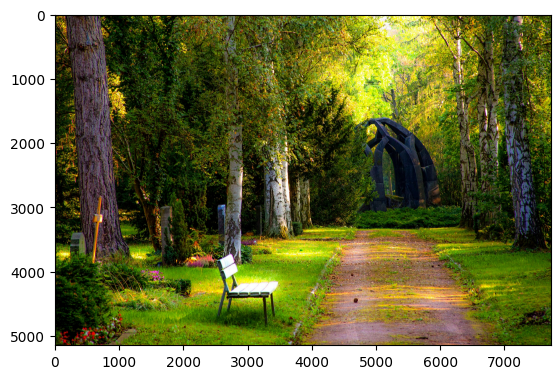

In [12]:
from PIL import Image

image = Image.open('..\\..\\files\\test_images\\park.jpg')

X = dinov2_transform(image).unsqueeze(dim=0).to(device)

# show image "image"
plt.imshow(image)


In [13]:
output = feature_extractor(X)

In [16]:
output[0].shape

torch.Size([1, 625, 384])

In [ ]:
output[0]

In [50]:
output[0].shape

torch.Size([384])

In [52]:
ft = output
ft = torch.flatten(ft, start_dim=1).detach().cpu().numpy()

In [53]:
ft.shape

(1, 384)

In [57]:
len(ft[0])

384

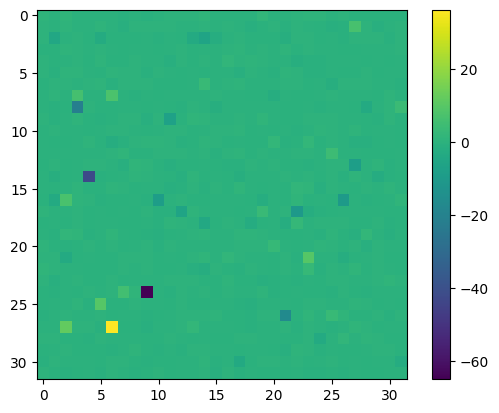

In [96]:
image_size = 350

import numpy as np
import matplotlib.pyplot as plt

# Assuming features is a numpy array of shape (1, 1024)
features = output 
features = features.cpu().detach().numpy()

# Reshape features to a square image shape
image_size = int(np.sqrt(features.shape[1]))
feature_image = features.reshape((image_size, image_size))

plt.imshow(feature_image, cmap='viridis')  # Use a suitable colormap
plt.colorbar()
plt.show()

### Hook feature extraction

In [96]:
import functools
from collections import OrderedDict

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427
def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

class IntermediateLayerGetter:
    def __init__(self, model, return_layers, keep_output=True):
        """Wraps a Pytorch module to get intermediate values
        
        Arguments:
            model {nn.module} -- The Pytorch module to call
            return_layers {dict} -- Dictionary with the selected submodules
            to return the output (format: {[current_module_name]: [desired_output_name]},
            current_module_name can be a nested submodule, e.g. submodule1.submodule2.submodule3)
        
        Keyword Arguments:
            keep_output {bool} -- If True model_output contains the final model's output
            in the other case model_output is None (default: {True})

        Returns:
            (mid_outputs {OrderedDict}, model_output {any}) -- mid_outputs keys are 
            your desired_output_name (s) and their values are the returned tensors
            of those submodules (OrderedDict([(desired_output_name,tensor(...)), ...).
            See keep_output argument for model_output description.
            In case a submodule is called more than one time, all it's outputs are 
            stored in a list.
        """
        self._model = model
        self.return_layers = return_layers
        self.keep_output = keep_output
        
    def __call__(self, *args, **kwargs):
        ret = OrderedDict()
        handles = []
        for name, new_name in self.return_layers.items():
            layer = rgetattr(self._model, name)
            
            def hook(module, input, output, new_name=new_name):
                if new_name in ret:
                    if type(ret[new_name]) is list:
                        ret[new_name].append(output)
                    else:
                        ret[new_name] = [ret[new_name], output]
                else:
                    ret[new_name] = output
            try:
                h = layer.register_forward_hook(hook)
            except AttributeError as e:
                raise AttributeError(f'Module {name} not found')
            handles.append(h)
            
        if self.keep_output:
            output = self._model(*args, **kwargs)
        else:
            self._model(*args, **kwargs)
            output = None
            
        for h in handles:
            h.remove()
        
        return ret, output

In [112]:
return_layers = {
    'blocks.0': 'blocks.0',
    'blocks.1': 'blocks.1',
    'blocks.2': 'c',
    'blocks.3': 'd',
    'blocks.0.ls2': '0',
    'blocks.1.ls2': '1',
    'blocks.2.ls2': '2',
    'blocks.2': '3',
    'blocks.11.ls2': '11',
    'norm': '12',
    'head': '13'
}

In [113]:
feature_extractor = IntermediateLayerGetter(model, return_layers=return_layers, keep_output=True)

In [114]:
mid_outputs, model_output = feature_extractor(X)

In [115]:
mid_outputs.keys()

odict_keys(['0', 'blocks.0', '1', 'blocks.1', '2', '3', 'd', '11', '12', '13'])

In [111]:
mid_outputs["1"][:,0].shape

torch.Size([1, 384])

In [144]:
ft = mid_outputs["1"]
ft = torch.flatten(ft, start_dim=1).detach().cpu().numpy()

In [150]:
ft.shape

(1, 240384)

In [231]:
mid_outputs["13"].shape

torch.Size([1, 384])

In [184]:
mid_outputs["3"].shape

torch.Size([1, 626, 384])

In [171]:
mid_outputs["0"].shape

torch.Size([1, 626, 384])

In [ ]:
block = 1

activation = {}
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.blocks[block].register_forward_hook(getActivation(str(block)))

model

In [5]:
class CustomNet(nn.Module):
    def __init__(self, num_outputs):
        super(CustomNet, self).__init__()
        
        # Caricamento del modello VGG-19 pre-addestrato
        model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        
        # Freeze the pre-trained layers
        for param in model.parameters():
            param.requires_grad = False
        
        # Utilizziamo solo i layer di feature extraction senza gli ultimi layer completamente connessi
        self.features = nn.Sequential(*list(model.features.children()))
        
        # Aggiunta del layer di average pooling
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        
        # Aggiunta del layer completamente connesso per la regressione
        self.fc = nn.Linear(512 * 7 * 7, num_outputs)  # L'input size 512 è determinato dal numero di feature maps generate dall'ultimo layer di VGG-19
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## VIT-GPT2-image-captioning

Preproc

In [145]:
encoder_list = ["encoder.0", "encoder.12", "encoder.3"]
decoder_list = ["decoder.1", "decoder.2", "decoder.12"]

# Scegliere tra encoder_list o decoder_list
selected_list = decoder_list  # Puoi cambiare questa assegnazione per scegliere tra le due liste

# Estrai il tipo di caratteristica ("encoder" o "decoder")
feature_type = selected_list[0].split('.')[0]

# Estrai i numeri dalla lista e crea una nuova lista
return_layers = [int(item.split('.')[1].strip()) for item in selected_list]

print("Tipo di caratteristica:", feature_type)
print("Numeri:", return_layers)

#return_layers = [int(string) for string in return_layers]

Tipo di caratteristica: decoder
Numeri: [1, 2, 12]


Model

In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer

Test transformer e xformers

In [4]:
from transformers import pipeline; print(pipeline('sentiment-analysis')('we love you'))

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Using C:\Users\giorg\AppData\Local\torch_extensions\torch_extensions\Cache\py39_cu116 as PyTorch extensions root...
Creating extension directory C:\Users\giorg\AppData\Local\torch_extensions\torch_extensions\Cache\py39_cu116\cuda_kernel...
Detected CUDA files, patching ldflags
Emitting ninja build file C:\Users\giorg\AppData\Local\torch_extensions\torch_extensions\Cache\py39_cu116\cuda_kernel\build.ninja...
Building extension module cuda_kernel...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module cuda_kernel...


[{'label': 'POSITIVE', 'score': 0.9998704195022583}]


In [3]:
print(torch.__version__)

1.13.0


In [149]:
pretrained_weights = "nlpconnect/vit-gpt2-image-captioning"
feature_type = "decoder" # ["encoder", "decoder"]
# Loading model from HuggingFace With Pre-trained Weights
model = VisionEncoderDecoderModel.from_pretrained(pretrained_weights)
# quello che qui è chiamato feature_extractor è in realtà il preprocessore delle immagini
feature_extractor = ViTImageProcessor.from_pretrained(
        pretrained_weights)
# il tokenizer serve per creare le caption, quindi non serve per l'estrazione delle features
tokenizer = AutoTokenizer.from_pretrained(pretrained_weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [151]:
# generate parameters (parametri per la generazione dell'encoder)
gen_kwargs = {"max_length": 16, "num_beams": 4,
                "return_dict_in_generate": True, "output_hidden_states": True}

ids = list()
features = list()
model.eval()


#pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values
#pixel_values = pixel_values.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [52]:
model.eval()

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

In [178]:
image_path = '..\\..\\files\\test_images\\surf.jpg'
img = Image.open(image_path).convert('RGB')
pixel_values = feature_extractor(
    images=img, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)
# print pixel_values shape and type
print(pixel_values.shape, pixel_values.dtype)
print(pixel_values.repeat(64, 1, 1,1).shape, pixel_values.repeat(64, 1, 1, 1).dtype)
# per usarlo come processer devo selezionare il primo (perchè funziona su singole immagini)
print(pixel_values[0].shape, pixel_values[0].dtype)

torch.Size([1, 3, 224, 224]) torch.float32
torch.Size([64, 3, 224, 224]) torch.float32
torch.Size([3, 224, 224]) torch.float32


In [154]:
# imagenet_V1_transform = transforms.Compose([
#     transforms.Resize((256,256)), # resize the images to 224x224 pixels (256x256)
#     transforms.CenterCrop(224), # IN THE OLDER SCRIPT: no center crop, only resize to 224x224
#     transforms.ToTensor(), # convert the images to a PyTorch tensor
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
#     # normalize the images color channels
#     # mean: [0.485, 0.456, 0.406] for the three channels
#     # std: [0.229, 0.224, 0.225] for the three channels
# ])
# image_path = '..\\..\\files\\test_images\\surf.jpg'
# img = Image.open(image_path).convert('RGB')
# pixel_values = imagenet_V1_transform(img)
# pixel_values = pixel_values.to(device)
# # print pixel_values shape and type
# print(pixel_values.shape, pixel_values.dtype)

torch.Size([3, 224, 224]) torch.float32


Ottengo il batch di immagini preprocessate:
- Tensore di dimensione (1, 3, 224, 224) (batch_size, channels, height, width)
- dtype: torch.float32

In [59]:
with torch.no_grad():
    feats = model.encoder(
        pixel_values, output_hidden_states=True).hidden_states
print(len(feats))
print(len(feats))
for i in feats:
    print(i.shape)

13
13
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


Ottengo una lista di 13 embedding (encoder):
- Sono i 13 livelli della rete
- shape si ognuno (batch_size, 197, 768)

In [177]:
feature_type = "decoder" # ["encoder", "decoder"]
if feature_type == "encoder":
    with torch.no_grad():
        feats = model.encoder(
            pixel_values, output_hidden_states=True).hidden_states #[-4:]
else:
    # perchè no torch.no_grad()? io lo metterei
    with torch.no_grad():
        feats = model.generate(
            pixel_values, **gen_kwargs).encoder_hidden_states #[-4:]

Ottengo una lista di 13 embedding (decoder):
- Sono i 13 livelli della rete
- shape si ognuno (batch_size, 197, 768)

In [159]:
print(len(feats))
print(type(feats))
for i in feats:
    print(i.shape)

13
<class 'tuple'>
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [148]:
# selezioni le feature del 12esimo layer per la prima immagine
feats[12][0]

tensor([[-12.9961,   2.1880,  10.1801,  ..., -15.0789,   0.8434,   3.0909],
        [-15.9037,   3.7306,  12.0943,  ..., -15.2853,  -4.0630,   1.1605],
        [-14.7114,  -5.4524,  12.9522,  ...,  -3.5896,   4.1848,  -2.6171],
        ...,
        [-16.8734,   2.3871,  21.1295,  ..., -14.2540,  -4.8677,  -1.1890],
        [-18.9686,  -1.2736,  22.7049,  ..., -10.5859,   0.5169,  -4.5945],
        [-17.3267,   4.9193,  15.9039,  ..., -15.5257,  -1.4643,   2.5733]],
       device='cuda:0')

Selezione dei layer embedding estratti data una lista di indici

In [144]:
list(map(feats.__getitem__, return_layers))[2]

tensor([[[-12.9961,   2.1880,  10.1801,  ..., -15.0789,   0.8434,   3.0909],
         [-15.9037,   3.7306,  12.0943,  ..., -15.2853,  -4.0630,   1.1605],
         [-14.7114,  -5.4524,  12.9522,  ...,  -3.5896,   4.1848,  -2.6171],
         ...,
         [-16.8734,   2.3871,  21.1295,  ..., -14.2540,  -4.8677,  -1.1890],
         [-18.9686,  -1.2736,  22.7049,  ..., -10.5859,   0.5169,  -4.5945],
         [-17.3267,   4.9193,  15.9039,  ..., -15.5257,  -1.4643,   2.5733]]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [157]:
tuple(map(feats.__getitem__, return_layers))[2]

tensor([[[-12.9961,   2.1880,  10.1801,  ..., -15.0789,   0.8434,   3.0909],
         [-15.9037,   3.7306,  12.0943,  ..., -15.2853,  -4.0630,   1.1605],
         [-14.7114,  -5.4524,  12.9522,  ...,  -3.5896,   4.1848,  -2.6171],
         ...,
         [-16.8734,   2.3871,  21.1295,  ..., -14.2540,  -4.8677,  -1.1890],
         [-18.9686,  -1.2736,  22.7049,  ..., -10.5859,   0.5169,  -4.5945],
         [-17.3267,   4.9193,  15.9039,  ..., -15.5257,  -1.4643,   2.5733]]],
       device='cuda:0')

In [158]:
print(len(feats))
for i in list(map(feats.__getitem__, return_layers)):
    print(i.shape)
    
print(len(feats))
for i in tuple(map(feats.__getitem__, return_layers)):
    print(i.shape)

13
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
13
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


Continuiamo quello che fa catosine

In [120]:
feats = [x for x in feats]
feats = torch.stack(feats[-4:]).cpu() # togli .cpu() se vuoi usare la gpu

- Trasformo tupla di feature in lista di feature
- Tengo solo le ultime 4 (ultimi 4 layer)
- le stacka per salvarle
  - CAMBIA: non farle stackare ma assegnale a un dizionario -> la seconda riga viene già eseguita nel feature_extraction process
  - CAMBIA: non convertirle in cpu e non trasformare inlista (va bene la tupla)

In [121]:
len(feats)
feats.shape

torch.Size([4, 1, 197, 768])

In [ ]:

features = feats[0]
features.shape

In [ ]:
len(feats)
feats.shape

Nel feature extractor poi, ogni

In [85]:
torch.flatten(feats[0], start_dim=1).shape # agg da me

torch.Size([1, 151296])

Con [:, 0] si seleziona quella della prima immagin

In [92]:
hs = feats[:, 0]
hs = hs.numpy().astype(np.float32)

# Lui poi le salva per ogni immagine in un file .npy
# for i in range(len(id)):
#     hs = feats[:, i]
#     hs = hs.numpy().astype(np.float32)

#     if not os.path.isdir(args.save_path):
#         os.makedirs(args.save_path)

#     np.save(os.path.join(args.save_path,
#             id[i].split(".")[0]+".npy"), hs)

In [93]:
hs.shape

(4, 197, 768)

Come creo il dizionario delle feature dati gli embedding e i nomi dei layer?

In [167]:
for i in tuple(map(feats.__getitem__, return_layers)):
    print(i.shape)
from collections import OrderedDict
ret = OrderedDict((key, value) for key, value in zip(decoder_list, tuple(map(feats.__getitem__, return_layers))))

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


In [169]:
for i in ret.keys():
    print(i)
    print(ret[i].shape)

decoder.1
torch.Size([1, 197, 768])
decoder.2
torch.Size([1, 197, 768])
decoder.12
torch.Size([1, 197, 768])


Come converto/flatteno delle feature torch.Size([2, 197, 768]) dove 2 è la batch size ?

In [170]:
new_tensor = feats[0].repeat(2, 1, 1)
new_tensor.shape

torch.Size([64, 197, 768])

In [163]:
torch.flatten(new_tensor, start_dim=1).detach().cpu().numpy().shape

(2, 151296)

In [37]:
for i in feats:
    print(i.shape)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


### Costruzione classe

In [ ]:
class VIT_GPT2_FeatureExtractor:
    def __init__(self, model, return_layers, pretrained_weights = "nlpconnect/vit-gpt2-image-captioning"):
        """Wraps a Pytorch DINOv2 module to get intermediate values
        Arguments:
            model {nn.module} -- The Pytorch module to call
            return_layers {list} -- List of blocks layer number e.g. [1,2,3] will take output [encoder.1,encoder.2,encoder.3] or [decoder.1,decoder.2,decoder.3] 
            feature_type {str} -- Define the block of ViTModel to extract. Encoder or decoder.
        Returns:
            When initialized, the class returns a feature extractor callable on a batch of images.
            When the feature extractor is called, it returns an OrderedDict with the requested layers as keys and the corresponding features as values.
        """
        self.pretrained_weights = pretrained_weights
        self.model = model
        # define "decoder" or "encoder"
        self.feature_type = return_layers[0].split('.')[0]
        # create the list of layers names for the dictionary
        self.model_layers = return_layers
        # parameters for decoder generation
        self.gen_kwargs = {"max_length": 16, "num_beams": 4,
                            "return_dict_in_generate": True, "output_hidden_states": True}
        if isinstance(return_layers, list):
            # delete ".decoder" or ".encoder" from the string and convert to int
            self.return_layers = [int(item.split('.')[1].strip()) for item in return_layers]
        else:
            print("Set model layers as lists even if single layer extraction.")
            return_layers = [return_layers]
            self.return_layers = [int(item.split('.')[1].strip()) for item in return_layers]
        self.number_of_blocks = 13
    def __call__(self, X):
        """
        Arguments:
            X: batch of images (torch tensor)
        """
        ret = OrderedDict()
        gen_kwargs = self.gen_kwargs
        if self.feature_type == "encoder":
            # extract features from all the encoder hidden layers
            with torch.no_grad():
                feats = self.model.encoder(
                    X, output_hidden_states=True).hidden_states #[-4:]
        else:
            # extract features from all the decoder hidden layers
            #with torch.no_grad():
            with torch.no_grad():
                feats = self.model.generate(
                    X, **gen_kwargs).encoder_hidden_states #[-4:]
        # select only the layers embeddings specified in return_layers
        feats = tuple(map(feats.__getitem__, self.return_layers))
        # create the dictionary keys: "encoder.1", "encoder.2", ... or "decoder.1", "decoder.2", ...
        # values: the corresponding embeddings
        ret = OrderedDict((key, value) for key, value in zip(self.model_layers, feats))
        return ret

pretrained_weights = "nlpconnect/vit-gpt2-image-captioning"
model = VisionEncoderDecoderModel.from_pretrained(pretrained_weights)
model.to(device) # send the model to the chosen device ('cpu' or 'cuda')
model.eval() # set the model to evaluation mode, since you are not training it
for param in model.parameters():
    param.requires_grad = False
feature_extractor = VIT_GPT2_FeatureExtractor(model, return_layers = decoder_list)

In [ ]:
ViT_GPT2_pretrained_weights = "nlpconnect/vit-gpt2-image-captioning"
ViT_GPT2_feature_extractor = ViTImageProcessor.from_pretrained(ViT_GPT2_pretrained_weights)

def ViT_GPT2_transform(img):
    return ViT_GPT2_feature_extractor(images=img, return_tensors="pt").pixel_values # [0]

In [ ]:
image_path = '..\\..\\files\\test_images\\surf.jpg'
img = Image.open(image_path).convert('RGB')
img = ViT_GPT2_transform(img)

In [ ]:
img.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# creo un finto batch
pixel_values = img.repeat(64, 1, 1,1)

In [ ]:
feats = feature_extractor(pixel_values.to(device))

In [ ]:
feats["decoder.1"].shape

torch.Size([64, 197, 768])

### Test su immagine

In [10]:
import urllib.parse as parse
import os
from PIL import Image

def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False

def load_image(image_path):
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)
    
def get_caption(model, image_processor, tokenizer, image_path):
    image = load_image(image_path)
    # preprocess the image
    img = image_processor(image, return_tensors="pt").to(device)
    # generate the caption (using greedy decoding by default)
    output = model.generate(**img)
    # decode the output
    caption = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    return caption

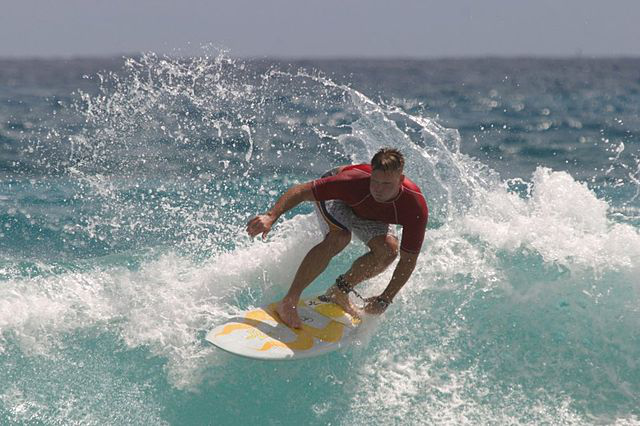

In [70]:
img = '..\\..\\files\\test_images\\surf.jpg'

display(load_image(image_path).convert('RGB'))

In [71]:
pixel_values = feature_extractor(
    images=img, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)

if args.feature_type == "encoder":
    with torch.no_grad():
        feats = model.encoder(
            pixel_values, output_hidden_states=True).hidden_states
else:
    feats = model.generate(
        pixel_values, **gen_kwargs).encoder_hidden_states

ValueError: Invalid image type. Expected either PIL.Image.Image, numpy.ndarray, torch.Tensor, tf.Tensor or jax.ndarray, but got <class 'str'>.

In [15]:
get_caption(model, feature_extractor, tokenizer, image_path)

c:\Users\giorg\miniconda3\envs\algonauts_test2\lib\site-packages\transformers\generation\utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a man riding a surfboard on top of a wave '

In [7]:
from PIL import Image

image = Image.open('..\\..\\files\\test_images\\park.jpg')

X = dinov2_transform(image).unsqueeze(dim=0).to(device)

# show image "image"
plt.imshow(image)

NameError: name 'dinov2_transform' is not defined

# Loss Functions

## Pearson

In [5]:
x.shape

torch.Size([10, 10])

In [12]:
def CCCLoss(x, y):
    ccc = (x.var() + y.var() + (x.mean() - y.mean())**2)
    return ccc

CCCLoss(x, y).grad_fn

### Torchmetrics PearsonCorrCoef

In [14]:
from torchmetrics import PearsonCorrCoef
x = torch.randn(10, 11, requires_grad=True)
y = torch.randn(10, 11, requires_grad=True)
pearson = PearsonCorrCoef(num_outputs=11)
pearson_calculated = torch.mean(pearson(x, y))
print(pearson_calculated.grad_fn)

In [18]:
# !pip install torchmetrics
from torchmetrics import PearsonCorrCoef
x = torch.randn(10, 11, requires_grad=True)
y = torch.randn(10, 11, requires_grad=True)

# Define the loss function
def PearsonMeanLoss(pred, target):
    # Create the PearsonCorrCoef object for the loss function
    pearson = PearsonCorrCoef(num_outputs=pred.shape[1])
    # Calculate the Pearson correlation coefficient between the prediction and target
    # where pred and target tensors are of shape (batch_size, num_variable)
    # Squared the coefficients and take the mean
    return torch.mean(torch.pow(pearson(pred, target),2))

def PearsonMedianLoss(pred, target):
    # Create the PearsonCorrCoef object for the loss function
    pearson = PearsonCorrCoef(num_outputs=pred.shape[1])
    # Calculate the Pearson correlation coefficient between the prediction and target
    # where pred and target tensors are of shape (batch_size, num_variable)
    # Squared the coefficients and take the median
    return torch.median(torch.pow(pearson(pred, target),2))

pearson_calculated = PearsonMedianLoss(x, y)
print(pearson_calculated.grad_fn)

In [20]:
import torch
from torch.autograd import Function, Variable

class PearsonCorrCoef(Function):
    @staticmethod
    def forward(ctx, input1, input2):
        # Compute the Pearson correlation coefficient between input1 and input2
        # where input1 and input2 tensors are of shape (batch_size, num_variable)
        # Return the coefficients as a tensor of shape (batch_size, num_variable)
        mean1 = input1.mean(dim=0, keepdim=True)
        mean2 = input2.mean(dim=0, keepdim=True)
        std1 = input1.std(dim=0, keepdim=True)
        std2 = input2.std(dim=0, keepdim=True)
        cov = ((input1 - mean1) * (input2 - mean2)).mean(dim=0, keepdim=True)
        corr_coef = cov / (std1 * std2)
        ctx.save_for_backward(input1, input2)
        return corr_coef

    @staticmethod
    def backward(ctx, grad_output):
        input1, input2 = ctx.saved_tensors
        # Compute the gradient of the Pearson correlation coefficient with respect to the inputs
        mean1 = input1.mean(dim=0, keepdim=True)
        mean2 = input2.mean(dim=0, keepdim=True)
        std1 = input1.std(dim=0, keepdim=True)
        std2 = input2.std(dim=0, keepdim=True)
        cov = ((input1 - mean1) * (input2 - mean2)).mean(dim=0, keepdim=True)
        corr_coef = cov / (std1 * std2)
        grad_input1 = grad_input2 = None
        if ctx.needs_input_grad[0]:
            grad_input1 = grad_output * (input2 - mean2) / (std1 * std2**2) - (corr_coef * grad_output).mean(dim=0, keepdim=True) * (input2 - mean2) / (std1 * std2**2)
        if ctx.needs_input_grad[1]:
            grad_input2 = grad_output * (input1 - mean1) / (std1**2 * std2) - (corr_coef * grad_output).mean(dim=0, keepdim=True) * (input1 - mean1) / (std1**2 * std2)
        return grad_input1, grad_input2

class CustomLoss(Function):
    @staticmethod
    def forward(ctx, pred, target):
        # Create the PearsonCorrCoef object for the loss function
        pearson = PearsonCorrCoef.apply
        # Calculate the Pearson correlation coefficient between the prediction and target
        # where pred and target tensors are of shape (batch_size, num_variable)
        # Squared the coefficients and take the median
        loss = torch.median(torch.pow(pearson(pred, target),2))
        ctx.save_for_backward(pred, target)
        return loss

    @staticmethod
    def backward(ctx, grad_output):
        pred, target = ctx.saved_tensors
        # Compute the gradient of the loss with respect to the prediction
        pearson = PearsonCorrCoef.apply
        corr_coef = pearson(pred, target)
        grad_input = torch.zeros_like(pred)
        for i in range(pred.shape[1]):
            grad_input[:, i] = 2 * torch.where(corr_coef[:, i] != 0, corr_coef[:, i], torch.ones_like(corr_coef[:, i])) * grad_output
        return grad_input, None

# Example usage
loss_fn = CustomLoss.apply
pred = Variable(torch.randn(10, 5), requires_grad=True)
target = Variable(torch.randn(10, 5))
loss = loss_fn(pred, target)
loss.backward()

In [21]:
loss

tensor(0.0169, grad_fn=<CustomLossBackward>)